In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [0]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

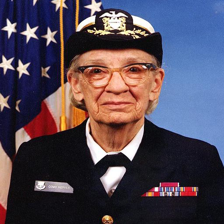

In [17]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [18]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [19]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [20]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

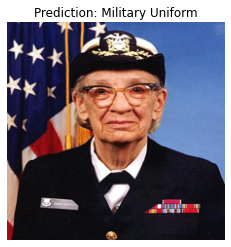

In [21]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [0]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [23]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [25]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['American Staffordshire terrier', 'carton', 'tabby', 'chow',
       'tabby', 'dalmatian', 'Italian greyhound', 'Siamese cat',
       'bull mastiff', 'Egyptian cat', 'Siamese cat', 'paper towel',
       'lynx', 'Persian cat', 'Labrador retriever', 'tabby', 'tabby',
       'Scottish deerhound', 'Pembroke', 'Cardigan', 'toy terrier',
       'Egyptian cat', 'Staffordshire bullterrier', 'tabby',
       'Persian cat', 'doormat', 'Egyptian cat', 'Chihuahua',
       'Egyptian cat', 'Egyptian cat', 'Egyptian cat', 'redbone'],
      dtype='<U30')

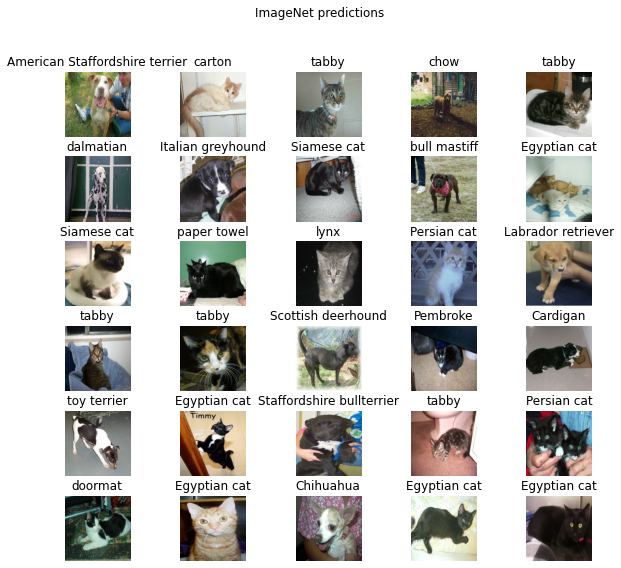

In [26]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [28]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

In [30]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 53s 91ms/step - loss: 0.0527 - accuracy: 0.9822 - val_loss: 0.0321 - val_accuracy: 0.9884
Epoch 2/6
582/582 [==============================] - 49s 85ms/step - loss: 0.0292 - accuracy: 0.9903 - val_loss: 0.0292 - val_accuracy: 0.9903
Epoch 3/6
582/582 [==============================] - 49s 85ms/step - loss: 0.0246 - accuracy: 0.9915 - val_loss: 0.0305 - val_accuracy: 0.9897
Epoch 4/6
582/582 [==============================] - 50s 85ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0300 - val_accuracy: 0.9903
Epoch 5/6
582/582 [==============================] - 50s 85ms/step - loss: 0.0192 - accuracy: 0.9932 - val_loss: 0.0309 - val_accuracy: 0.9897
Epoch 6/6
582/582 [==============================] - 49s 84ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.0316 - val_accuracy: 0.9899


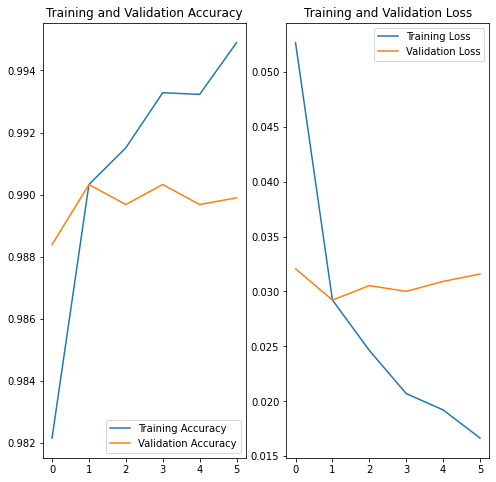

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [34]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog',
       'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog',
       'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat',
       'dog', 'cat', 'cat', 'cat', 'dog'], dtype='<U3')

In [35]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1]
Predicted labels:  [1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1]


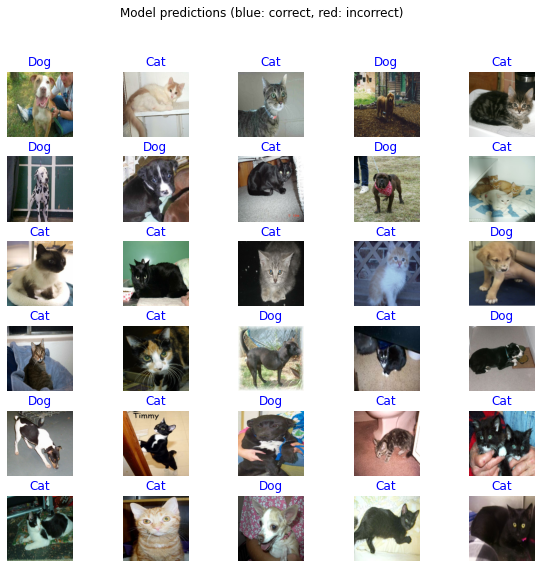

In [36]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")